In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFTGate, DiagonalGate
import imageio.v2 as imageio
import os
import shutil

In [11]:
HBAR = 1.0
M = 0.5
TWO_M = 2 * M 

# Grid Parameters
N_QUBITS = 7              # Keep it small for clarity (128 points)
N_GRID = 2**N_QUBITS
X_MAX = 30.0
L = 2 * X_MAX

# Time Parameters
dt = 0.05                 # Larger step since we have no potential (exact evolution)
n_steps = 100
frames_to_save = 50

# --- 2. GRID DEFINITION (The Source of Truth) ---
# We define ONE spatial grid and ONE momentum grid for both methods.
dx = L / N_GRID
x_grid = np.linspace(-L/2, L/2, N_GRID, endpoint=False)

# Standard FFT Momentum Grid: [0, dk, 2dk, ... -dk]
# This is the layout QFT output produces naturally.
k_grid = fftfreq(N_GRID, d=dx) * (2 * np.pi)

# =============================================================================
# --- 3. INITIALIZATION ---
# =============================================================================
def get_initial_state(x, k0, x0, sigma):
    # Gaussian Wavepacket
    norm_factor = 1.0 / (np.sqrt(sigma * np.sqrt(np.pi)))
    psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
    # Normalize numerically to be safe
    psi /= np.linalg.norm(psi)
    return psi

# Physics: Moving Gaussian
k0_target = 2.0
x0_start = -10.0
sigma_start = 2.0

# Create States
psi_ed = get_initial_state(x_grid, k0_target, x0_start, sigma_start)
psi_q = psi_ed.copy() # Copy for Qiskit initialization

# =============================================================================
# --- 4. OPERATORS ---
# =============================================================================

# --- A. ED Operator (Split-Step T only) ---
# T_op in k-space is diagonal
T_k_vals = (HBAR * k_grid)**2 / TWO_M
# Evolution operator for one step
U_k_ed = np.exp(-1j * T_k_vals * dt / HBAR)

# --- B. Qiskit Operator (Exact Diagonal Mapping) ---
# We construct a gate that applies EXACTLY the same phases as ED
# This bypasses any "integer arithmetic" errors.
U_k_qiskit = DiagonalGate(U_k_ed)

# Qiskit Step Circuit: QFT -> Phase -> IQFT
qc_step = QuantumCircuit(N_QUBITS)
qc_step.append(QFTGate(N_QUBITS), range(N_QUBITS))
qc_step.append(U_k_qiskit, range(N_QUBITS))
qc_step.append(QFTGate(N_QUBITS).inverse(), range(N_QUBITS))

# =============================================================================
# --- 5. SIMULATION LOOP ---
# =============================================================================

# Prepare output directory
output_dir = "kinetic_test"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

frame_files = []
steps_per_frame = n_steps // frames_to_save
if steps_per_frame < 1: steps_per_frame = 1

# Initialize Qiskit Statevector
sv = Statevector(psi_q)

print("Starting Kinetic-Only Simulation...")

for step in range(n_steps + 1):
    
    # --- 1. Save Frame ---
    if step % steps_per_frame == 0:
        # Get Data
        psi_q_data = sv.data
        
        # Calculate Fidelity
        overlap = np.vdot(psi_ed, psi_q_data)
        fidelity = np.abs(overlap)**2
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(x_grid, np.abs(psi_ed)**2, 'b-', lw=4, alpha=0.5, label="ED (Exact)")
        plt.plot(x_grid, np.abs(psi_q_data)**2, 'r--', lw=1.5, label="Qiskit (QFT)")
        
        # Formatting
        plt.title(f"Kinetic Evolution Only: Step {step}")
        plt.xlabel("Position x")
        plt.ylabel("Probability Density")
        plt.ylim(0, 0.15)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Fidelity Box
        plt.text(0.05, 0.95, f"Fidelity: {fidelity:.6f}", 
                 transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.8))
        
        fname = os.path.join(output_dir, f"frame_{step:04d}.png")
        plt.savefig(fname)
        plt.close()
        frame_files.append(fname)
        
        print(f"Step {step}: Fidelity = {fidelity:.6f}")
        
    # --- 2. Evolution Step ---
    
    # ED Step: FFT -> Phase -> IFFT
    psi_k = fft(psi_ed)
    psi_k = psi_k * U_k_ed
    psi_ed = ifft(psi_k)
    
    # Qiskit Step: Evolve with circuit
    sv = sv.evolve(qc_step)

# =============================================================================
# --- 6. CREATE GIF ---
# =============================================================================
gif_name = "kinetic_only_benchmark.gif"
images = [imageio.imread(f) for f in frame_files]
imageio.mimsave(gif_name, images, duration=0.1, loop=0)

print(f"Animation saved to {gif_name}")
# Clean up frames
shutil.rmtree(output_dir)

Starting Kinetic-Only Simulation...
Step 0: Fidelity = 1.000000
Step 2: Fidelity = 1.000000
Step 4: Fidelity = 1.000000
Step 6: Fidelity = 1.000000
Step 8: Fidelity = 1.000000
Step 10: Fidelity = 1.000000
Step 12: Fidelity = 1.000000
Step 14: Fidelity = 1.000000
Step 16: Fidelity = 1.000000
Step 18: Fidelity = 1.000000
Step 20: Fidelity = 1.000000
Step 22: Fidelity = 1.000000
Step 24: Fidelity = 1.000000
Step 26: Fidelity = 1.000000
Step 28: Fidelity = 1.000000
Step 30: Fidelity = 1.000000
Step 32: Fidelity = 1.000000
Step 34: Fidelity = 1.000000
Step 36: Fidelity = 1.000000
Step 38: Fidelity = 1.000000
Step 40: Fidelity = 1.000000
Step 42: Fidelity = 1.000000
Step 44: Fidelity = 1.000000
Step 46: Fidelity = 1.000000
Step 48: Fidelity = 1.000000
Step 50: Fidelity = 1.000000
Step 52: Fidelity = 1.000000
Step 54: Fidelity = 1.000000
Step 56: Fidelity = 1.000000
Step 58: Fidelity = 1.000000
Step 60: Fidelity = 1.000000
Step 62: Fidelity = 1.000000
Step 64: Fidelity = 1.000000
Step 66: Fid

In [37]:
N=2**4
dx = 10 / (N-1)
x = np.linspace(-10/2, 10/2 , N)
p = fftfreq(N, d=dx) * (2 * np.pi * 1)

In [39]:
print(x)
print(dx)
print(p)
print(-np.pi/(dx))

[-5.         -4.33333333 -3.66666667 -3.         -2.33333333 -1.66666667
 -1.         -0.33333333  0.33333333  1.          1.66666667  2.33333333
  3.          3.66666667  4.33333333  5.        ]
0.6666666666666666
[ 0.          0.58904862  1.17809725  1.76714587  2.35619449  2.94524311
  3.53429174  4.12334036 -4.71238898 -4.12334036 -3.53429174 -2.94524311
 -2.35619449 -1.76714587 -1.17809725 -0.58904862]
-4.71238898038469


In [29]:
def check_momentum_step():
    # --- 1. Setup Parameters ---
    n_q = 3              # Let's say 3 qubits
    N = 2**n_q           # N = 8 points
    dx = 1.0             # Spacing (delta x) = 1 for simplicity
    
    # Total physical length L = N * dx
    L = N * dx 

    # --- 2. Run fftfreq ---
    # np.fft.fftfreq(n, d) returns values in cycles/unit
    # We multiply by 2*pi to turn "cycles" into "radians" (k)
    f_values = np.fft.fftfreq(N, d=dx)
    k_values = 2 * np.pi * f_values

    # --- 3. Verify the Step Size (dk) ---
    # The step is the difference between the first two values (k[1] - k[0])
    calculated_dk = k_values[1] - k_values[0]
    
    # The theoretical physics step is 2*pi / L  (or 2*pi / (N*dx))
    theoretical_dk = (2 * np.pi) / L

    # --- 4. Output Results ---
    print(f"Number of points (N): {N}")
    print(f"Spacing (dx): {dx}")
    print("-" * 30)
    print(f"Raw fftfreq output (f):   {f_values}")
    print(f"Converted to radians (k): {np.round(k_values, 3)}")
    print("-" * 30)
    print(f"Calculated step (dk):  {calculated_dk}")
    print(f"Theoretical 2pi/N*dx:  {theoretical_dk}")
    
    # Check if they are essentially equal
    if np.isclose(calculated_dk, theoretical_dk):
        print("\n✅ SUCCESS: The step size is exactly 2pi / (N*dx)")
    else:
        print("\n❌ FAIL: The values do not match.")

check_momentum_step()

Number of points (N): 8
Spacing (dx): 1.0
------------------------------
Raw fftfreq output (f):   [ 0.     0.125  0.25   0.375 -0.5   -0.375 -0.25  -0.125]
Converted to radians (k): [ 0.     0.785  1.571  2.356 -3.142 -2.356 -1.571 -0.785]
------------------------------
Calculated step (dk):  0.7853981633974483
Theoretical 2pi/N*dx:  0.7853981633974483

✅ SUCCESS: The step size is exactly 2pi / (N*dx)


In [14]:
HBAR = 1.0
M = 0.5
TWO_M = 2 * M 

# Grid Parameters
N_QUBITS = 9             # 512 grid points
N_GRID = 2**N_QUBITS
X_MAX = 60.0
L = 2 * X_MAX

# Simulation Parameters
Vb = 8.0                 # Barrier Height
w = 2.0                  # Barrier Separation
b = 0.5                  # Barrier Width
barrier_regions = [(-w/2 - b, -w/2), (w/2, w/2 + b)]

E_target = 10.0          # Wavepacket Energy
k0_target = np.sqrt(TWO_M * E_target) / HBAR
x0 = -30.0
sigma = 4.0

dt = 0.005               # Time step
total_steps = 2000
frames_to_save = 60

dx = L / N_GRID
x_grid = np.linspace(-L/2, L/2, N_GRID, endpoint=False)
# Standard FFT momentum grid: [0, dk, ..., -dk]
k_grid = fftfreq(N_GRID, d=dx) * (2 * np.pi)

In [ ]:
def get_potential_profile(x_grid, barrier_regions, Vb):
    """Creates the V(x) array."""
    V = np.zeros_like(x_grid)
    for (b_min, b_max) in barrier_regions:
        mask = (x_grid >= b_min) & (x_grid <= b_max)
        V[mask] = Vb
    return V

def build_trotter_circuit(n_qubits, dt, V_x, k_grid):
    """
    Builds a single Strang Splitting Step: exp(-iV dt/2) exp(-iT dt) exp(-iV dt/2)
    Using Exact Diagonal Gates for both T and V.
    """
    qc = QuantumCircuit(n_qubits)
    
    # 1. Pre-compute Phases
    # Potential Phase (V * dt/2)
    phase_V_half = np.exp(-1j * V_x * (dt / 2) / HBAR)
    
    # Kinetic Phase (T * dt) = (p^2/2m * dt)
    # Note: k_grid must be the standard fftfreq order!
    T_vals = (HBAR * k_grid)**2 / TWO_M
    phase_T = np.exp(-1j * T_vals * dt / HBAR)
    
    # 2. Construct Circuit Layers
    
    # A. First Potential Half-Step (Position Basis)
    qc.append(DiagonalGate(phase_V_half), range(n_qubits))
    
    # B. Kinetic Step (Momentum Basis)
    qc.append(QFTGate(n_qubits), range(n_qubits))  # x -> p
    qc.append(DiagonalGate(phase_T), range(n_qubits)) # Since fftfreq momentum labelling is different, we ensure here that the same grid is utilized instead of trying to find the ZZ circuit decomposition.
    qc.append(QFTGate(n_qubits).inverse(), range(n_qubits)) # p -> x
    
    # C. Second Potential Half-Step (Position Basis)
    qc.append(DiagonalGate(phase_V_half), range(n_qubits))
    
    return qc

# =============================================================================
# --- 4. INITIALIZATION & PLOTTING ---
# =============================================================================

def get_initial_state(x, k0, x0, sigma):
    psi = np.exp(-(x - x0)**2 / (4 * sigma**2)) * np.exp(1j * k0 * x)
    psi /= np.linalg.norm(psi)
    return psi

def plot_frame(x_grid, psi_ed, psi_q, fidelity, time, barrier_regions, filename, ymax):
    prob_ed = np.abs(psi_ed)**2
    prob_q = np.abs(psi_q)**2
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x_grid, prob_ed, 'b-', label='ED (Reference)', linewidth=1.5, alpha=0.8)
    ax.plot(x_grid, prob_q, 'r--', label='Qiskit (Trotter)', linewidth=1.5, alpha=0.8)
    
    # Shade barriers
    for (b_min, b_max) in barrier_regions:
        ax.fill_between([b_min, b_max], 0, ymax, color='gray', alpha=0.3, 
                        label='Barrier' if b_min == barrier_regions[0][0] else "")

    ax.set_ylim(0, ymax)
    ax.set_xlabel("Position (x)")
    ax.set_ylabel("Probability Density $|\\psi(x)|^2$")
    ax.set_title(f"Trotterized Scattering: t = {time:.2f}")
    ax.legend(loc='upper right')
    ax.grid(True, linestyle=':', alpha=0.5)
    
    # Fidelity Box
    ax.text(0.05, 0.95, f"Fidelity: {fidelity:.6f}", transform=ax.transAxes, 
            fontsize=14, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig(filename, dpi=100)
    plt.close()

# =============================================================================
# --- 5. MAIN ANIMATION LOOP ---
# =============================================================================

def create_animation():
    print("Initializing Simulation...")
    
    # 1. Physics Objects
    V_x = get_potential_profile(x_grid, barrier_regions, Vb)
    
    # 2. Initial State
    psi_ed = get_initial_state(x_grid, k0_target, x0, sigma)
    
    # 3. Qiskit Setup
    qc_step = build_trotter_circuit(N_QUBITS, dt, V_x, k_grid)
    step_op = Operator(qc_step) # Convert circuit to operator for fast evolution
    sv_q = Statevector(psi_ed)  # Initialize exactly the same as ED
    
    # 4. ED Propagators (Split-Step)
    exp_V_half = np.exp(-1j * V_x * (dt / 2) / HBAR)
    exp_T = np.exp(-1j * (HBAR * k_grid)**2 / TWO_M * dt / HBAR)
    
    # 5. Plotting Setup
    initial_prob = np.abs(psi_ed)**2
    global_ymax = np.max(initial_prob) * 1.3
    
    frame_dir = "trotter_frames"
    if os.path.exists(frame_dir):
        shutil.rmtree(frame_dir)
    os.makedirs(frame_dir)
    
    frame_files = []
    current_time = 0.0
    steps_per_frame = total_steps // frames_to_save
    
    print(f"Starting Evolution (Total Steps: {total_steps})...")
    
    for step in range(total_steps + 1):
        
        # Save Frame
        if step % steps_per_frame == 0:
            overlap = np.vdot(psi_ed, sv_q.data)
            fidelity = np.abs(overlap)**2
            
            fname = os.path.join(frame_dir, f"frame_{step:04d}.png")
            plot_frame(x_grid, psi_ed, sv_q.data, fidelity, current_time, 
                       barrier_regions, fname, global_ymax)
            frame_files.append(fname)
            print(f"  Step {step}/{total_steps}: Fidelity = {fidelity:.6f}")
            
        if step == total_steps:
            break
            
        # --- Evolution Step ---
        
        # 1. ED (Split Step Fourier)
        psi_ed = exp_V_half * psi_ed    # V/2
        psi_ed = fft(psi_ed)            # x -> p
        psi_ed = exp_T * psi_ed         # T
        psi_ed = ifft(psi_ed)           # p -> x
        psi_ed = exp_V_half * psi_ed    # V/2
        
        # 2. Qiskit (Matrix Multiplication)
        sv_q = sv_q.evolve(step_op)
        
        current_time += dt

    # --- Stitch GIF ---
    output_gif = "Trotterized_Scattering_Final.gif"
    print(f"Stitching frames into {output_gif}...")
    images = [imageio.imread(f) for f in frame_files]
    duration = 6.0 / len(frame_files)
    imageio.mimsave(output_gif, images, duration=duration, loop=0)
    
    shutil.rmtree(frame_dir)
    print("Done! Animation saved.")

In [16]:
create_animation()

Initializing Simulation...
Starting Evolution (Total Steps: 2000)...
  Step 0/2000: Fidelity = 1.000000
  Step 33/2000: Fidelity = 1.000000
  Step 66/2000: Fidelity = 1.000000
  Step 99/2000: Fidelity = 1.000000
  Step 132/2000: Fidelity = 1.000000
  Step 165/2000: Fidelity = 1.000000
  Step 198/2000: Fidelity = 1.000000
  Step 231/2000: Fidelity = 1.000000
  Step 264/2000: Fidelity = 1.000000
  Step 297/2000: Fidelity = 1.000000
  Step 330/2000: Fidelity = 1.000000
  Step 363/2000: Fidelity = 1.000000
  Step 396/2000: Fidelity = 1.000000
  Step 429/2000: Fidelity = 1.000000
  Step 462/2000: Fidelity = 1.000000
  Step 495/2000: Fidelity = 1.000000
  Step 528/2000: Fidelity = 1.000000
  Step 561/2000: Fidelity = 1.000000
  Step 594/2000: Fidelity = 1.000000
  Step 627/2000: Fidelity = 1.000000
  Step 660/2000: Fidelity = 1.000000
  Step 693/2000: Fidelity = 1.000000
  Step 726/2000: Fidelity = 1.000000
  Step 759/2000: Fidelity = 1.000000
  Step 792/2000: Fidelity = 1.000000
  Step 825/

Computing Exact Diagonalization Evolution...

Steps      | dt         | Infidelity
----------------------------------------
5          | 0.4000     | 9.70e-01
10         | 0.2000     | 7.53e-01
20         | 0.1000     | 2.89e-01
40         | 0.0500     | 2.01e-03
80         | 0.0250     | 9.05e-05
160        | 0.0125     | 5.36e-06


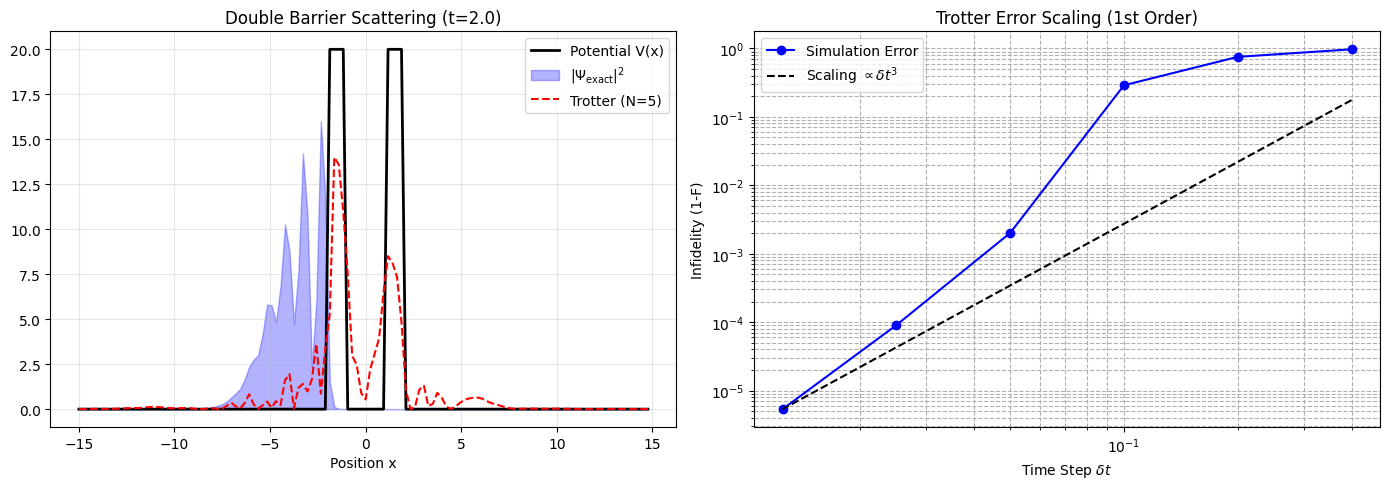

In [43]:
from scipy.linalg import expm

def double_barrier_trotter_test():
    # --- 1. System Configuration ---
    N = 128                 # Grid size (keep < 500 for dense matrix operations)
    L = 30.0                # Box size
    mass = 1.0
    t_final = 2.0           # Time to evolve
    
    # Grid setup
    dx = L / N
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    
    # Momentum Grid (using the symmetric derivation)
    k = 2 * np.pi * np.fft.fftfreq(N, d=dx)
    k = np.fft.fftshift(k) # Sort for T construction logic
    
    # --- 2. Define Double Barrier Potential V(x) ---
    V0 = 20.0               # Barrier height
    barrier_width = 1.0
    separation = 2.0        # Distance between barriers
    
    # Create the potential array
    V_diag = np.zeros(N)
    # Barrier 1 (Left)
    mask1 = (x > -separation/2 - barrier_width) & (x < -separation/2)
    # Barrier 2 (Right)
    mask2 = (x > separation/2) & (x < separation/2 + barrier_width)
    
    V_diag[mask1 | mask2] = V0
    V_matrix = np.diag(V_diag)

    # --- 3. Define Kinetic Energy T (Dense Matrix) ---
    # T is diagonal in k-space, but dense in x-space.
    # We build T_k then transform it: T_x = F_dag * T_k * F
    
    T_diag_k = (k**2) / (2 * mass)
    
    # Create DFT matrix F (normalized)
    # F[m, n] = exp(-2pi*i * m * n / N) / sqrt(N)
    n_indices = np.arange(N)
    m_indices = np.arange(N)
    # Outer product to make grid
    M, K = np.meshgrid(m_indices, n_indices)
    F = np.exp(-2j * np.pi * M * K / N) / np.sqrt(N)
    F_dag = np.conj(F).T
    
    # Note: To handle the fftshift in 'k', we need to be careful with F ordering.
    # Alternatively, easier approach for dense T matrix using FFT helper:
    # We apply FFT to columns of Identity to get the transformation matrix.
    F_op = np.fft.fft(np.eye(N)) / np.sqrt(N)
    F_op_inv = np.fft.ifft(np.eye(N)) * np.sqrt(N)
    
    # Re-calculate T_diag_k based on standard fftfreq order (unsorted) for this op
    k_unsorted = 2 * np.pi * np.fft.fftfreq(N, d=dx)
    T_diag_k_unsorted = (k_unsorted**2) / (2 * mass)
    
    T_matrix = F_op_inv @ np.diag(T_diag_k_unsorted) @ F_op

    # --- 4. Initial State (Gaussian Wavepacket) ---
    # Start on the left, moving right towards the barriers
    x0 = -8.0
    k0 = 4.0  # Initial momentum kick
    sigma = 1.0
    
    psi_0 = np.exp(-(x - x0)**2 / (2*sigma**2)) * np.exp(1j * k0 * x)
    psi_0 = psi_0 / np.linalg.norm(psi_0) # Normalize

    # --- 5. EXACT Evolution (The Gold Standard) ---
    print("Computing Exact Diagonalization Evolution...")
    H_total = T_matrix + V_matrix
    
    # U_exact = exp(-iHt)
    U_exact = expm(-1j * H_total * t_final)
    psi_exact = U_exact @ psi_0

    # --- 6. Trotter Evolution (The Approximation) ---
    # We will verify that Error scales with dt^2 (for 1st order Lie-Trotter global error scales as dt)
    # Using 1st Order: U ~ (e^-iTdt e^-iVdt)^N
    
    steps_list = [5, 10, 20, 40, 80, 160]
    errors = []
    dts = []

    print(f"\n{'Steps':<10} | {'dt':<10} | {'Infidelity'}")
    print("-" * 40)
    
    for n_steps in steps_list:
        dt = t_final / n_steps
        dts.append(dt)
        
        # Build small propagators
        U_V_step = np.diag(np.exp(-1j * V_diag * dt/2))
        # For T, we already have the matrix, we can exponentiate it
        # (In real quantum algos, this is done via QFT, but here we just want the matrix math)
        U_T_step = expm(-1j * T_matrix * dt)
        
        # Trotter Step (T then V)
        U_step = U_V_step @ U_T_step @ U_V_step
        
        # Evolve
        psi_trotter = psi_0.copy()
        # Using matrix power for efficiency in simulation (U^N)
        U_total_trotter = np.linalg.matrix_power(U_step, n_steps)
        psi_trotter = U_total_trotter @ psi_0
        
        # Calculate Infidelity: 1 - |<exact|trotter>|^2
        overlap = np.vdot(psi_exact, psi_trotter)
        infidelity = 1 - np.abs(overlap)**2
        errors.append(infidelity)
        
        print(f"{n_steps:<10} | {dt:<10.4f} | {infidelity:.2e}")

    # --- 7. Visualization ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: The Physics (Potential + Wavefunction)
    ax1.set_title(f"Double Barrier Scattering (t={t_final})")
    ax1.plot(x, V_diag, 'k-', linewidth=2, label="Potential V(x)")
    # Scale wavefunction for visibility
    scale = np.max(V_diag) if np.max(V_diag) > 0 else 1.0
    prob_dens = np.abs(psi_exact)**2
    ax1.fill_between(x, prob_dens * (scale/np.max(prob_dens)) * 0.8, color='b', alpha=0.3, label=r"$|\Psi_{\rm exact}|^2$")
    
    # Show the Trotterized version for the worst case (fewest steps) to see distortion
    # Re-run specifically for visualization
    dt_bad = t_final / steps_list[0]
    U_bad = np.linalg.matrix_power(np.diag(np.exp(-1j*V_diag*dt_bad)) @ expm(-1j*T_matrix*dt_bad), steps_list[0])
    psi_bad = U_bad @ psi_0
    ax1.plot(x, np.abs(psi_bad)**2 * (scale/np.max(prob_dens)) * 0.8, 'r--', label=f"Trotter (N={steps_list[0]})")
    
    ax1.set_xlabel("Position x")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot 2: The Error Scaling
    ax2.set_title("Trotter Error Scaling (1st Order)")
    ax2.loglog(dts, errors, 'bo-', label="Simulation Error")
    
    # Reference line for O(dt^2) - Infidelity often scales as dt^2 for 1st order Trotter
    # (Amplitude error is dt, Probability error is dt^2)
    ref = np.array(dts)**3
    # Anchor reference line to last point
    ref = ref * (errors[-1] / ref[-1])
    ax2.loglog(dts, ref, 'k--', label=r"Scaling $\propto \delta t^3$")
    
    ax2.set_xlabel(r"Time Step $\delta t$")
    ax2.set_ylabel("Infidelity (1-F)")
    ax2.grid(True, which="both", linestyle='--')
    ax2.legend()

    plt.tight_layout()
    plt.show()

double_barrier_trotter_test()